### Importer les librairies de machine learning

In [1]:
import numpy as np
import pandas as pd

import poutyne as pt
from poutyne import Model
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

### Ajuster les hyperparamètres

In [2]:
test_ratio = 0.2
valid_ratio = 0.5

hidden_size = 512
output_size = 8
dropout = 0.0

n_epochs = 30
batch_size = 32
learning_rate = 0.1
min_lr=0.00001
momentum = 0.9

gamma = 0.1
patience = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Charger le dataframe traité, le séparer en datasets et créer les DataLoaders

In [3]:
# Load data/dataframe.csv file as a pandas dataframe
df = pd.read_csv('data/dataframe.csv')

input_size = len(df.columns) - 2 # Retirer le ID et l'étiquette

# Convert into a tensor
dataset = torch.tensor(df.values)

# Split into train and test
train_data, test_data = train_test_split(dataset, test_size=test_ratio)

# Split train into train and validation
test_data, val_data = train_test_split(test_data, test_size=valid_ratio)

# Split train into X and y without the firs column
X_train, y_train = train_data[:, 1:-1].float(), train_data[:, -1].long()
X_val, y_val = val_data[:, 1:-1].float(), val_data[:, -1].long()
X_test, y_test = test_data[:, 1:-1].float(), test_data[:, -1].long()

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
# print shape of df
print(df.shape)

(74992, 32)


### Créer l'algorithme FC

In [4]:
class FCNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(FCNetwork, self).__init__()
        self.dropout1 = nn.Dropout(dropout)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)

        hidden_size_2 = hidden_size
        self.dropout2 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, hidden_size_2)
        self.bn2 = nn.BatchNorm1d(hidden_size_2)

        hidden_size_3 = hidden_size // 2
        self.dropout3 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.bn3 = nn.BatchNorm1d(hidden_size_3)

        hidden_size_4 = hidden_size // 4
        self.dropout4 = nn.Dropout(dropout)
        self.fc4 = nn.Linear(hidden_size_3, hidden_size_4)
        self.bn4 = nn.BatchNorm1d(hidden_size_4)

        hidden_size_5 = hidden_size // 8
        self.dropout5 = nn.Dropout(dropout)
        self.fc5 = nn.Linear(hidden_size_4, hidden_size_5)
        self.bn5 = nn.BatchNorm1d(hidden_size_5)

        self.fc6 = nn.Linear(hidden_size_5, output_size)

    def forward(self, x):
        x = self.dropout1(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout3(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout4(x)
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout5(x)
        x = F.relu(self.bn5(self.fc5(x)))
        x = self.fc6(x)
        y = F.log_softmax(x, dim=1)
        return y

### Créer le modèle Poutyne

In [5]:
network = FCNetwork(input_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
scheduler = pt.ReduceLROnPlateau(monitor="val_acc", mode='max', patience=patience, factor=gamma, min_lr=min_lr, verbose=True)
model = Model(network, optimizer, criterion, device=device, batch_metrics=["accuracy"])

### Entraîner le modèle sur les données d'entraînement

In [6]:
history = model.fit_generator(train_loader, val_loader, epochs=n_epochs, callbacks=[scheduler])
torch.cuda.empty_cache()

Epoch:  1/30 Train steps: 1875 Val steps: 235 7.72s loss: 1.497525 acc: 45.828680 val_loss: 1.306995 val_acc: 51.693333
Epoch:  2/30 Train steps: 1875 Val steps: 235 7.17s loss: 1.284816 acc: 53.372894 val_loss: 1.147441 val_acc: 56.880000
Epoch:  3/30 Train steps: 1875 Val steps: 235 7.55s loss: 1.169417 acc: 57.345024 val_loss: 1.039714 val_acc: 62.026667
Epoch:  4/30 Train steps: 1875 Val steps: 235 7.31s loss: 1.093895 acc: 60.128682 val_loss: 1.019630 val_acc: 62.546667
Epoch:  5/30 Train steps: 1875 Val steps: 235 7.34s loss: 1.042589 acc: 61.695531 val_loss: 0.941383 val_acc: 65.746667
Epoch:  6/30 Train steps: 1875 Val steps: 235 7.50s loss: 0.993607 acc: 63.554081 val_loss: 0.944207 val_acc: 65.520000
Epoch:  7/30 Train steps: 1875 Val steps: 235 7.42s loss: 0.959809 acc: 64.689214 val_loss: 0.885580 val_acc: 67.133333
Epoch:  8/30 Train steps: 1875 Val steps: 235 7.39s loss: 0.923294 acc: 66.041038 val_loss: 0.850452 val_acc: 69.013333
Epoch:  9/30 Train steps: 1875 Val steps

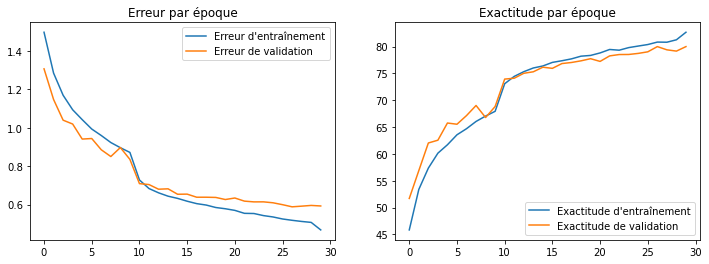

In [7]:
loss_per_epoch = []
acc_per_epoch = []
val_loss_per_epoch = []
val_acc_per_epoch = []
for epoch in history:
    loss_per_epoch.append(epoch['loss'])
    acc_per_epoch.append(epoch['acc'])
    val_loss_per_epoch.append(epoch['val_loss'])
    val_acc_per_epoch.append(epoch['val_acc'])

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_per_epoch, label='Erreur d\'entraînement')
plt.plot(val_loss_per_epoch, label='Erreur de validation')
plt.title('Erreur par époque')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_per_epoch, label='Exactitude d\'entraînement')
plt.plot(val_acc_per_epoch, label='Exactitude de validation')
plt.title('Exactitude par époque')
plt.legend()
plt.show()

### Évaluer le modèle sur les données de test

#### Obtenir les prédictions

In [12]:
predictions = model.predict_generator(test_loader, has_ground_truth=True)

# Obtenir la classe ayant le plus grand score
predicted_classes = predictions.argmax(axis=1)

# Obtenir les labels test
ground_truth = test_data[:, -1].long().numpy()

Prediction steps: 235 0.37s                                            


#### Calculer la matrice de confusion

In [9]:
classes = [
    'Another party (please specify)',
    'Bloc Qu<e9>b<e9>cois',
    'Conservative Party',
    "Don't know/ Prefer not to answer",
    'Green Party',
    'Liberal Party',
    'ndp',
    "People's Party"
]
classes_idx = [0, 1, 2, 3, 4, 5, 6, 7]

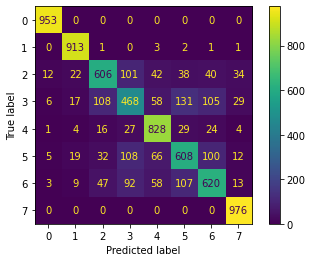

In [10]:
cm = confusion_matrix(ground_truth, predicted_classes, labels=classes_idx)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

#### Calculer les métriques de performance

In [11]:
accuracy = accuracy_score(ground_truth, predicted_classes)
precision = precision_score(ground_truth, predicted_classes, average=None)
recall = recall_score(ground_truth, predicted_classes, average=None)
f1 = f1_score(ground_truth, predicted_classes, average=None)

print(f"Accuracy: {accuracy:.2%}")

df_metrics = pd.DataFrame({"Precision": precision, "Recall": recall, "F1-Score": f1}, index=classes)

df_metrics = df_metrics.applymap(lambda x: f"{x:.2%}")
df_metrics

Accuracy: 79.64%


,Precision,Recall,F1-Score
Another party (please specify),97.24%,100.00%,98.60%
Bloc Qu<e9>b<e9>cois,92.78%,99.13%,95.85%
Conservative Party,74.81%,67.71%,71.09%
Don't know/ Prefer not to answer,58.79%,50.76%,54.48%
Green Party,78.48%,88.75%,83.30%
Liberal Party,66.45%,64.00%,65.20%
ndp,69.66%,65.33%,67.43%
People's Party,91.30%,100.00%,95.45%
